# Trabalho 2 - Introdução à Ciência de Dados

### Larissa Lewartoski Wong

## Dataset escolhido: Diabetes

#### O dataset está disponível em: https://www.openml.org/search?type=data&sort=runs&id=37&status=active

## Definição do dataset

* O dados que integram o dataset são referentes à mulheres com pelo menos 21 anos com herança dos Pima (povo nativo dos Estados Unidos da América).
* O objetivo do dataset é predizer se uma paciente tem diabetes com base em outras medidas de diagnóstico.
* Este dataset foi criado com dados de outro dataset maior, por meio de restrições.
* Possui 8 atributos (e a classe)
* Possui 768 instâncias
* Todos os atributos são numéricos. Apenas a classe sendo atributo nominal.

#### Em relação aos atributos:

- class(target): é o atributo que classifica se testou positivo ou negativo para diabetes;
- preg: número de vezes em que esteve grávida;
- plas: concentração de glicose plasmática obtida em teste de oral tolerância à glicose;
- pres: pressão sanguínea diastólica;
- skin: grossura da pele da dobra do tríceps;
- insu: insulina sérica de duas horas (professor não faço ideia do que seja isso);
- mass: índice de massa corporal;
- pedi: função de pedigree de diabetes (função que estima a chance de desenvolvimento de diabetes baseada em histórico familiar);
- age: idade da paciente.

#### Em relação à distribuição de classes: a distribuição é analisada no documento, obtendo 65.1% de testes negativos e 35.9% de testes positivos.

### Imports necessários

In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from fancyimpute import IterativeImputer
from scipy.stats import ttest_ind


## Carregando o dataset

#### A variável header nomeia as colunas

#### Os parâmetros passados para a função read_csv incluem:
* comment='@' - para ignorar as linhas que se iniciam com @
* skiprows - para ignorar as linhas anteriores à 84 (foi observado no arquivo arff que os dados começam após essas linhas)

In [38]:
header = ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class']
diabetes = pd.read_csv('dataset_37_diabetes.arff', comment='@', skiprows=84, header=None, na_values=['?'], names=header)

In [39]:
diabetes

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,tested_negative
764,2,122,70,27,0,36.8,0.340,27,tested_negative
765,5,121,72,23,112,26.2,0.245,30,tested_negative
766,1,126,60,0,0,30.1,0.349,47,tested_positive


## Convertendo Nominais em Numéricos

* Testes positivos serão convertidos em 1
* Testes negativos em 0 

In [40]:
diabetes['class'] = [0 if x == 'tested_negative' else 1 for x in diabetes['class']]
diabetes_default = diabetes.copy()

## Tratando valores ausentes

#### Observou-se que os valores ausentes estão representados como 0 em alguns atributos como insulina

In [41]:
colunas_substituir = ['plas', 'pres', 'skin', 'insu', 'mass', 'pedi']
diabetes[colunas_substituir] = diabetes[colunas_substituir].replace(0, np.nan)

### Utilizando MICE para completar os atributos faltantes

In [42]:
imputer = IterativeImputer()

diabetes_imputado = imputer.fit_transform(diabetes)
diabetes_imputado = pd.DataFrame(diabetes_imputado, columns=diabetes.columns)

## Normalizando os dados

In [43]:
scaler = MinMaxScaler()
diabetes_norm = pd.DataFrame(scaler.fit_transform(diabetes_default), columns= diabetes_default.columns)
diabetes_norm_mice = pd.DataFrame(scaler.fit_transform(diabetes_imputado), columns = diabetes_imputado.columns)

## Verificando a distribuição de classes

* Com base na distribuição de classes obtida foi escolhido não realizar o balanceamento

Negatives: 500 | Positives: 268


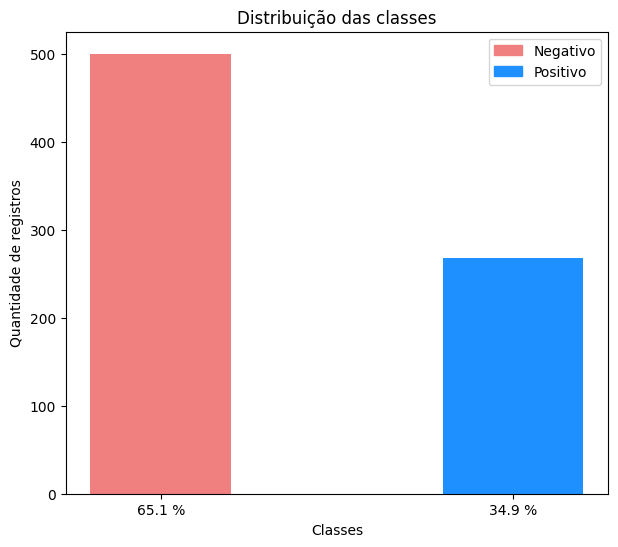

In [44]:
zero = diabetes_norm[diabetes_norm['class'] == 0]['class'].size
one = diabetes_norm[diabetes_norm['class'] == 1]['class'].size

size = diabetes_norm['class'].size
zero_label = str(round(zero*100/diabetes_norm['class'].size, 2)) + " %"
one_label = str(round(one*100/diabetes_norm['class'].size, 2)) + " %"

print('Negatives: {} | Positives: {}'.format(zero, one))
fig = plt.figure(figsize = (7, 6))
plt.bar([zero_label,one_label], [zero, one], color =['lightcoral', 'dodgerblue'],
        width = 0.4)
plt.xlabel("Classes")
plt.ylabel("Quantidade de registros")
plt.title("Distribuição das classes")
colors = {'Negativo':'lightcoral', 'Positivo':'dodgerblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

## Separando o dataset em 5 folds

* Serão geradas 5 partes iguais para realização de comparação posterior. Foram escolhidas 5 partes em razão do tamanho do dataset, para não resultar em partes muito pequenas.

In [45]:
kf = KFold(n_splits=5)

# Classificador default

* Para o classificador default foram utilizados os parâmetros definidos na especificação do trabalho:
    - K = 3
    - Distância Euclideana

As etapas de pré processamento para aplicação do KNN foram realizadas acima (normalização e conversão para atributos numéricos)

In [46]:
knn_default = KNeighborsClassifier(n_neighbors=3, metric='euclidean')

X_default = diabetes_norm.drop(['class'], axis=1)
y_default = diabetes_norm['class']

## Acurácia para o default utilizando 5-fold cross validation

- KNN sem mice com k=3 e distância euclideana

In [47]:
acuracia_default_sem_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_default.fit(X_train, y_train)
    
    y_pred1 = knn_default.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_default_sem_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_default_sem_mice = sum(acuracia_default_sem_mice) / len(acuracia_default_sem_mice) * 100


print("Acurácia média do default: {:.2f}%".format(acuracia_media_default_sem_mice))


Fold 0: 75.32%
Fold 1: 66.88%
Fold 2: 73.38%
Fold 3: 76.47%
Fold 4: 71.90%
Acurácia média do default: 72.79%


# Modelos sugeridos

### Para desenvolvimento dos modelos sugeridos foram testados valores de k: 3, 5, 7, 9 e 11 para verificar se alterar o valor poderia ser uma opção viável de melhoria do modelo mantendo a distância euclideana. Também foram considerados: peso uniforme e peso relacionado às distâncias dos vizinhos e dataframes com valores ausentes e valores preenchidos com MICE.

In [48]:
X_mice = diabetes_norm_mice.drop(['class'], axis=1)
y_mice = diabetes_norm_mice['class']

## Testes sem MICE

### Variando o número de vizinhos

### Com peso uniforme no KNN

#### Teste 1 k=5

In [49]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')

acuracia_n5_uniforme = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5_uniforme.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5_uniforme = sum(acuracia_n5_uniforme) / len(acuracia_n5_uniforme) * 100


print("Acurácia média k=5: {:.2f}%".format(acuracia_media_n5_uniforme))

Fold 0: 77.92%
Fold 1: 66.88%
Fold 2: 73.38%
Fold 3: 78.43%
Fold 4: 73.20%
Acurácia média k=5: 73.96%


#### Teste 2 k=7

In [50]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='uniform')

acuracia_n7_uniforme = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7_uniforme.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7_uniforme) / len(acuracia_n7_uniforme) * 100


print("Acurácia média k=7: {:.2f}%".format(acuracia_media_n7))

Fold 0: 76.62%
Fold 1: 68.83%
Fold 2: 76.62%
Fold 3: 79.08%
Fold 4: 75.82%
Acurácia média k=7: 75.40%


#### Teste 3 k=9

In [51]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='uniform')

acuracia_n9_uniforme = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9_uniforme.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9_uniforme) / len(acuracia_n9_uniforme) * 100


print("Acurácia média k=9: {:.2f}%".format(acuracia_media_n9))

Fold 0: 72.73%
Fold 1: 72.73%
Fold 2: 76.62%
Fold 3: 76.47%
Fold 4: 74.51%
Acurácia média k=9: 74.61%


#### Teste 4 k=11

In [52]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform')

acuracia_n11_uniforme = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11_uniforme.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11_uniforme) / len(acuracia_n11_uniforme) * 100


print("Acurácia média k=11: {:.2f}%".format(acuracia_media_n11))

Fold 0: 75.97%
Fold 1: 70.13%
Fold 2: 75.32%
Fold 3: 79.08%
Fold 4: 73.86%
Acurácia média k=11: 74.87%


### Variando o número de vizinhos

### Com peso inversamente proporcional à distância dos vizinhos

#### Teste 1 k=3

In [53]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='distance')

acuracia_n3_distancia = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n3.fit(X_train, y_train)
    
    y_pred1 = knn_n3.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n3_distancia.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n3 = sum(acuracia_n3_distancia) / len(acuracia_n3_distancia) * 100


print("Acurácia média k=3: {:.2f}%".format(acuracia_media_n3))

Fold 0: 74.68%
Fold 1: 66.88%
Fold 2: 72.73%
Fold 3: 75.82%
Fold 4: 72.55%
Acurácia média k=3: 72.53%


#### Teste 2 k=5

In [54]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

acuracia_n5_distancia = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5_distancia.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5 = sum(acuracia_n5_distancia) / len(acuracia_n5_distancia) * 100

print("Acurácia média k=5: {:.2f}%".format(acuracia_media_n5))

Fold 0: 77.27%
Fold 1: 66.23%
Fold 2: 73.38%
Fold 3: 77.78%
Fold 4: 73.86%
Acurácia média k=5: 73.70%


#### Teste 3 k=7

In [55]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='distance')

acuracia_n7_distancia = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7_distancia.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7_distancia) / len(acuracia_n7_distancia) * 100


print("Acurácia média k=7: {:.2f}%".format(acuracia_media_n7))

Fold 0: 76.62%
Fold 1: 67.53%
Fold 2: 76.62%
Fold 3: 79.74%
Fold 4: 76.47%
Acurácia média k=7: 75.40%


#### Teste 4 k=9

In [56]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='distance')

acuracia_n9_distancia = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9_distancia.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9_distancia) / len(acuracia_n9_distancia) * 100


print("Acurácia média k=9: {:.2f}%".format(acuracia_media_n9))

Fold 0: 74.68%
Fold 1: 72.08%
Fold 2: 76.62%
Fold 3: 76.47%
Fold 4: 75.16%
Acurácia média k=9: 75.00%


#### Teste 5 k=11

In [57]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='distance')

acuracia_n11_distancia = []

for i, (train_index, test_index) in enumerate(kf.split(X_default)):
    X_train, X_test = X_default.iloc[train_index], X_default.iloc[test_index]
    y_train, y_test = y_default.iloc[train_index], y_default.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11_distancia.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11_distancia) / len(acuracia_n11_distancia) * 100


print("Acurácia média k=11: {:.2f}%".format(acuracia_media_n11))

Fold 0: 76.62%
Fold 1: 70.13%
Fold 2: 74.68%
Fold 3: 79.74%
Fold 4: 73.86%
Acurácia média k=11: 75.00%


## Testes com MICE

### Variando o número de vizinhos 
### Com peso uniforme no KNN

#### Teste 1 k=3

In [58]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='uniform')

acuracia_n3_uniforme_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n3.fit(X_train, y_train)
    
    y_pred1 = knn_n3.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n3_uniforme_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n3 = sum(acuracia_n3_uniforme_mice) / len(acuracia_n3_uniforme_mice) * 100


print("Acurácia média k=3 utilizando mice: {:.2f}%".format(acuracia_media_n3))

Fold 0: 74.03%
Fold 1: 70.78%
Fold 2: 73.38%
Fold 3: 73.20%
Fold 4: 73.20%
Acurácia média k=3 utilizando mice: 72.92%


#### Teste 2 k=5

In [59]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')

acuracia_n5_uniforme_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5_uniforme_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5 = sum(acuracia_n5_uniforme_mice) / len(acuracia_n5_uniforme_mice) * 100


print("Acurácia média k=5 utilizando mice: {:.2f}%".format(acuracia_media_n5))

Fold 0: 74.68%
Fold 1: 72.73%
Fold 2: 75.97%
Fold 3: 79.08%
Fold 4: 73.86%
Acurácia média k=5 utilizando mice: 75.26%


#### Teste 3 k=7

In [60]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='uniform')

acuracia_n7_uniforme_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7_uniforme_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7_uniforme_mice) / len(acuracia_n7_uniforme_mice) * 100


print("Acurácia média k=7 utilizando mice: {:.2f}%".format(acuracia_media_n7))

Fold 0: 75.32%
Fold 1: 72.08%
Fold 2: 75.97%
Fold 3: 79.08%
Fold 4: 74.51%
Acurácia média k=7 utilizando mice: 75.39%


#### Teste 4 k=9

In [61]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='uniform')

acuracia_n9_uniforme_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9_uniforme_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9_uniforme_mice) / len(acuracia_n9_uniforme_mice) * 100


print("Acurácia média k=9 utilizando mice: {:.2f}%".format(acuracia_media_n9))

Fold 0: 74.03%
Fold 1: 70.78%
Fold 2: 74.03%
Fold 3: 79.74%
Fold 4: 76.47%
Acurácia média k=9 utilizando mice: 75.01%


#### Teste 5 k=11

In [62]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform')

acuracia_n11_uniforme_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11_uniforme_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11_uniforme_mice) / len(acuracia_n11_uniforme_mice) * 100


print("Acurácia média k=11 utilizando mice: {:.2f}%".format(acuracia_media_n11))

Fold 0: 73.38%
Fold 1: 68.18%
Fold 2: 75.32%
Fold 3: 79.74%
Fold 4: 76.47%
Acurácia média k=11 utilizando mice: 74.62%


### Variando o número de vizinhos

### Com peso inversamente proporcional à distância dos vizinhos

#### Teste 1 k=3

In [63]:
knn_n3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='distance')

acuracia_n3_distancia_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n3.fit(X_train, y_train)
    
    y_pred1 = knn_n3.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n3_distancia_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n3 = sum(acuracia_n3_distancia_mice) / len(acuracia_n3_distancia_mice) * 100


print("Acurácia média k=3 utilizando mice: {:.2f}%".format(acuracia_media_n3))

Fold 0: 74.03%
Fold 1: 70.78%
Fold 2: 72.73%
Fold 3: 73.20%
Fold 4: 71.90%
Acurácia média k=3 utilizando mice: 72.53%


#### Teste 2 k=5

In [64]:
knn_n5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

acuracia_n5_distancia_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n5.fit(X_train, y_train)
    
    y_pred1 = knn_n5.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n5_distancia_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n5 = sum(acuracia_n5_distancia_mice) / len(acuracia_n5_distancia_mice) * 100


print("Acurácia média k=5 utilizando mice: {:.2f}%".format(acuracia_media_n5))

Fold 0: 75.32%
Fold 1: 72.08%
Fold 2: 75.97%
Fold 3: 79.08%
Fold 4: 72.55%
Acurácia média k=5 utilizando mice: 75.00%


#### Teste 3 k=7

In [65]:
knn_n7 = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='distance')

acuracia_n7_distancia_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n7.fit(X_train, y_train)
    
    y_pred1 = knn_n7.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n7_distancia_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n7 = sum(acuracia_n7_distancia_mice) / len(acuracia_n7_distancia_mice) * 100


print("Acurácia média k=7 utilizando mice: {:.2f}%".format(acuracia_media_n7))

Fold 0: 75.32%
Fold 1: 72.08%
Fold 2: 75.97%
Fold 3: 79.74%
Fold 4: 73.20%
Acurácia média k=7 utilizando mice: 75.26%


#### Teste 4 k=9

In [66]:
knn_n9 = KNeighborsClassifier(n_neighbors=9, metric='euclidean', weights='distance')

acuracia_n9_distancia_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n9.fit(X_train, y_train)
    
    y_pred1 = knn_n9.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n9_distancia_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n9 = sum(acuracia_n9_distancia_mice) / len(acuracia_n9_distancia_mice) * 100


print("Acurácia média k=9 utilizando mice: {:.2f}%".format(acuracia_media_n9))

Fold 0: 72.73%
Fold 1: 70.78%
Fold 2: 73.38%
Fold 3: 80.39%
Fold 4: 75.82%
Acurácia média k=9 utilizando mice: 74.62%


#### Teste 5 k=11

In [67]:
knn_n11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='distance')

acuracia_n11_distancia_mice = []

for i, (train_index, test_index) in enumerate(kf.split(X_mice)):
    X_train, X_test = X_mice.iloc[train_index], X_mice.iloc[test_index]
    y_train, y_test = y_mice.iloc[train_index], y_mice.iloc[test_index]
    
    knn_n11.fit(X_train, y_train)
    
    y_pred1 = knn_n11.predict(X_test)
    
    acuracia = accuracy_score(y_test, y_pred1)
    
    acuracia_n11_distancia_mice.append(acuracia)
    
    print(f"Fold {i}: {acuracia*100.0:.2f}%")
    
acuracia_media_n11 = sum(acuracia_n11_distancia_mice) / len(acuracia_n11_distancia_mice) * 100


print("Acurácia média k=11 utilizando mice: {:.2f}%".format(acuracia_media_n11))

Fold 0: 72.73%
Fold 1: 68.83%
Fold 2: 74.03%
Fold 3: 81.05%
Fold 4: 75.82%
Acurácia média k=11 utilizando mice: 74.49%


# T Student para comparar o baseline com os modelos propostos

#### Foram geradas estatísticas de comparações realizadas par a par (baseline X modelo proposto) sem MICE. Essas estatísticas foram inseridas no DataFrame t_student_sem_mice

*Os dataframes possuem os atributos:
| Variável       | Descrição                                                       |
|----------------|-----------------------------------------------------------------|
| stat   | Valor da estatística de t student                                       |
| p      | P-valor de t student                                                    |
| k      | Número de vizinhos considerado                                          |
| peso   |'uniforme' ou 'distancia' - tipo de peso utilizado no KNN                |
| mice   |'sim' ou 'não' - indica se foi utilizado MICE ou não para aquele modelo  |

In [68]:
colunas = {'stat': [], 'p':[], 'k':[], 'peso':[], 'mice':[]}

t_student_sem_mice = pd.DataFrame(colunas)

# Para k=5 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n5_uniforme)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 5, 'uniforme', 'não']

# Para k=7 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n7_uniforme)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 7, 'uniforme', 'não']

# Para k=9 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n9_uniforme)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 9, 'uniforme', 'não']

# Para k=11 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n11_uniforme)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 11, 'uniforme', 'não']

# Para k=3 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n3_distancia)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 3, 'distancia', 'não']

# Para k=5 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n5_distancia)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 5, 'distancia', 'não']

# Para k=7 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n7_distancia)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 7, 'distancia', 'não']

# Para k=9 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n9_distancia)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 9, 'distancia', 'não']

# Para k=11 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n11_distancia)
t_student_sem_mice.loc[len(t_student_sem_mice)] = [stat, p, 11, 'distancia', 'não']

t_student_sem_mice

,stat,p,k,peso,mice
0,-0.439175,0.672155,5,uniforme,não
1,-1.082492,0.310580,7,uniforme,não
2,-0.969378,0.360747,9,uniforme,não
3,-0.938073,0.375660,11,uniforme,não
4,0.114267,0.911842,3,distancia,não
5,-0.343649,0.739967,5,distancia,não
6,-0.982536,0.354613,7,distancia,não
7,-1.186837,0.269337,9,distancia,não
8,-0.960920,0.364732,11,distancia,não


#### Foram geradas estatísticas de comparações realizadas par a par (baseline X modelo proposto) com MICE. Essas estatísticas foram inseridas no DataFrame t_student_com_mice

In [69]:
colunas = {'stat': [], 'p':[], 'k':[], 'peso':[], 'mice':[]}

t_student_com_mice = pd.DataFrame(colunas)

# Para k=3 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n3_uniforme_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 3, 'uniforme', 'sim']

# Para k=5 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n5_uniforme_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 5, 'uniforme', 'sim']

# Para k=7 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n7_uniforme_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 7, 'uniforme', 'sim']

# Para k=9 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n9_uniforme_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 9, 'uniforme', 'sim']

# Para k=11 e peso uniforme
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n11_uniforme_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 11, 'uniforme', 'sim']

# Para k=3 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n3_distancia_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 3, 'distancia', 'sim']

# Para k=5 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n5_distancia_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 5, 'distancia', 'sim']

# Para k=7 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n7_distancia_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 7, 'distancia', 'sim']

# Para k=9 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n9_distancia_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 9, 'distancia', 'sim']

# Para k=11 e peso proporcional à distância
stat, p = ttest_ind(acuracia_default_sem_mice, acuracia_n11_distancia_mice)
t_student_com_mice.loc[len(t_student_com_mice)] = [stat, p, 11, 'distancia', 'sim']

t_student_com_mice

,stat,p,k,peso,mice
0,-0.072209,0.944208,3,uniforme,sim
1,-1.237710,0.250916,5,uniforme,sim
2,-1.288087,0.233721,7,uniforme,sim
3,-0.990249,0.351054,9,uniforme,sim
4,-0.719573,0.492271,11,uniforme,sim
5,0.149687,0.884717,3,distancia,sim
6,-1.052790,0.323194,5,distancia,sim
7,-1.159985,0.279501,7,distancia,sim
8,-0.777369,0.459309,9,distancia,sim
9,-0.651453,0.533018,11,distancia,sim


### Concatenação dos dataframes com os valores de t student

In [70]:
t_student = pd.concat([t_student_sem_mice, t_student_com_mice])
t_student

,stat,p,k,peso,mice
0,-0.439175,0.672155,5,uniforme,não
1,-1.082492,0.310580,7,uniforme,não
2,-0.969378,0.360747,9,uniforme,não
3,-0.938073,0.375660,11,uniforme,não
4,0.114267,0.911842,3,distancia,não
5,-0.343649,0.739967,5,distancia,não
6,-0.982536,0.354613,7,distancia,não
7,-1.186837,0.269337,9,distancia,não
8,-0.960920,0.364732,11,distancia,não
0,-0.072209,0.944208,3,uniforme,sim


# Análise dos p-values obtidos com t student

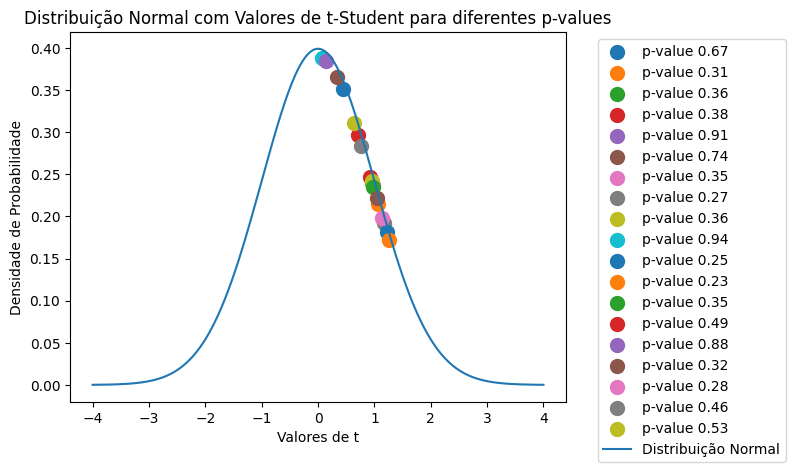

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

df = 10  # graus de liberdade

x = np.linspace(-4, 4, num=250)
pdf_normal = norm.pdf(x)

p_values = t_student['p']  # níveis de significância
for p in p_values:
    t_value = t.ppf(1 - p / 2, df=df)  # valor de t-Student para o nível de significância p
    pdf_t = t.pdf(x, df=df)
    plt.scatter(t_value, t.pdf(t_value, df=df), s=100, label=f'p-value {p:.2}')

plt.plot(x, pdf_normal, label='Distribuição Normal')
plt.xlabel('Valores de t')
plt.ylabel('Densidade de Probabilidade')
plt.title('Distribuição Normal com Valores de t-Student para diferentes p-values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Definindo a hipótese nula como: o modelo baseline é o melhor modelo para esse problema de classificação.
### A porcentagem de acurácia obtida com o baseline foi 72.79%. A melhor porcentagem de acurácia obtida foi 75.40% utilizando k=7, com distância uniforme e atributos ausentes.
### Com base nos valores e no gráfico obtido foi possível concluir que não há diferença estatística entre o modelo baseline e os outros modelos propostos após as mudanças (MICE, mudanças no k e mudanças na forma de avaliação de peso do KNN) pois os p values obtidos estavam entre 0.05 e 0.95. 
### Com base nisso conclui-se que a hipótese nula não deve ser rejeitada.